In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# define style 
plt.style.use('bmh')
plt.rcParams["font.family"] = "helvetica"

# expand pd display for debugging
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# define functions
# function for leave-one-out cross validation
def loso_cv(session_id, data, y_test_arr, y_pred_arr):
    # get unique session_id (which represent one unique subject) & split data into two parts: data from that subject
    # and data from everyone else
    LOOCV_O = session_id
    data_filtered = data[data['session_id'] != LOOCV_O]
    data_cv = data[data['session_id'] == LOOCV_O]
    
    # create test and train data
    X_test = data_cv.drop(columns=['selected', 'session_id'])
    y_test = data_cv['selected'] 
    X_train = data_filtered.drop(columns=['selected', 'session_id'])
    
    X_train = np.array(X_train)
    y_train = np.array(data_filtered['selected'])
    
    # fit logistic regression model
    res = sm.Logit(y_train.astype('float64'), X_train.astype('float64')).fit()
    print("training #", i, "completed")
                 
    # get predicted values   
    y_pred = res.predict(X_test)
    print("prediction completed")
    
    # add them to the ground truth values (y_test_arr) and predicted values (y_pred_arr) arrays 
    for x in y_test: 
        y_test_arr.append(x)
    for z in y_pred: 
        y_pred_arr.append(z)
                   
    return

# function to get unique session ids in the dataset
def unique(list1):
    unique_list = [] 
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)

# function to get profession category of each profession in the dataset
def get_profession_category(profession):
    all_professions = ['state governor','congress member', 'police officer', 'union leader','nurse', 'engineer', 'doctor', 'pharmacist', 'advertising practitioner', 'business executive', 'stockbroker', 'insurance salesperson', 'lawyer', 'journalist', 'university professor', 'clergy']
    gov_related = ['state governor','congress member', 'police officer', 'union leader'] # return 1 
    stem_related = ['nurse', 'engineer', 'doctor', 'pharmacist'] # return 2 
    business_related = ['advertising practitioner', 'business executive', 'stockbroker', 'insurance salesperson'] # return 3        
    other = ['lawyer', 'journalist', 'university professor', 'clergy'] # return 4
    
    # depending on which array a profession is in, return an integer value that represents that category
    if profession in gov_related:
        return(1)
    elif profession in stem_related:
        return(2)
    elif profession in business_related:
        return(3)
    elif profession in other:
        return(4)

# Prepare Conjoint Dataset

In [3]:
# read dataset with results into pd dataframe
results = pd.read_csv('datasets/results.csv')
users = pd.read_csv('datasets/users.csv')

In [4]:
# create a dict with user political party self-identification
politics_dict = pd.Series(users.user_politics.values,index=users.user_id).to_dict()

In [5]:
# map political party self-identification to each response
results["user_politics"] = results["user_id"].map(politics_dict)

In [6]:
# calculate in a variable whether the user completing this task deviated fromt the suggested advisor:
# made_changes = 0 -> no deviations, the suggested advisor attributes were reselected, made_changes = 1 ->
# at least one attribute was changed compared to the suggested advisor
results['made_changes'] = results['age_changed'] | results['gender_changed'] | results['race_changed'] | results['profession_changed']

In [7]:
# set up an empty dataframe to contain profiles of advisors that were 'selected'
dataset_conjoint_selected = pd.DataFrame(columns=['session_id', 'response_id', 'user_id', 'expense_category', 'expense', 'age','gender','race', 'profession', 'profession_category', 'selected', 'user_politics', 'task_submit_time'])

In [8]:
# set up an empty dataframe to contain profiles of advisors that were 'not selected'
dataset_conjoint_not_selected = pd.DataFrame(columns=['session_id', 'response_id', 'user_id', 'expense_category', 'expense', 'age','gender','race', 'profession', 'profession_category', 'selected', 'user_politics', 'task_submit_time'])

In [9]:
# populate the dataframe of selected advisor profiles, iterate through the results dataframe rows:
j = 0
for index, row in results.iterrows():
    # if a task did not involve making any changes and the suggested advisor attributes were reselected, 
    # then the suggested advisor attributes can be used to form a profile (consisting of an age, gender, race, 
    # and profession) that is considered preferable and thus 'selected'
    if(row['made_changes']==0):
        dataset_conjoint_selected.loc[index, 'session_id'] = row['session_id']
        dataset_conjoint_selected.loc[index, 'response_id'] = row['response_id']
        dataset_conjoint_selected.loc[index, 'user_id'] = row['user_id']
        dataset_conjoint_selected.loc[index, 'expense_category'] = row['expense_category']
        dataset_conjoint_selected.loc[index, 'expense'] = row['expense']
        dataset_conjoint_selected.loc[index, 'age'] = row['age_suggested']
        dataset_conjoint_selected.loc[index, 'gender'] = row['gender_suggested']
        dataset_conjoint_selected.loc[index, 'race'] = row['race_suggested']
        dataset_conjoint_selected.loc[index, 'profession'] = row['profession_suggested']
        dataset_conjoint_selected.loc[index, 'profession_category'] = get_profession_category(row['profession_suggested'])
        dataset_conjoint_selected.loc[index, 'selected'] = int(1)
        dataset_conjoint_selected.loc[index, 'user_politics'] = row['user_politics']
        dataset_conjoint_selected.loc[index, 'task_submit_time'] = row['task_submit_time']
    # if a task *did* involve making at least one change to the suggested advisor attributes, 
    # then the newly selected advisor attributes can be used to form a profile (consisting of an age, gender, race, 
    # and profession) that is considered preferable and thus 'selected'
    else:
        dataset_conjoint_selected.loc[index, 'session_id'] = row['session_id']
        dataset_conjoint_selected.loc[index, 'response_id'] = row['response_id']
        dataset_conjoint_selected.loc[index, 'user_id'] = row['user_id']
        dataset_conjoint_selected.loc[index, 'expense_category'] = row['expense_category']
        dataset_conjoint_selected.loc[index, 'expense'] = row['expense']
        dataset_conjoint_selected.loc[index, 'age'] = row['age_selected']
        dataset_conjoint_selected.loc[index, 'gender'] = row['gender_selected']
        dataset_conjoint_selected.loc[index, 'race'] = row['race_selected']
        dataset_conjoint_selected.loc[index, 'profession'] = row['profession_selected']
        dataset_conjoint_selected.loc[index, 'profession_category'] = get_profession_category(row['profession_selected'])
        dataset_conjoint_selected.loc[index, 'selected'] = int(1)
        dataset_conjoint_selected.loc[index, 'user_politics'] = row['user_politics']
        dataset_conjoint_selected.loc[index, 'task_submit_time'] = row['task_submit_time']
    j = j + 1

In [10]:
# populate the dataframe of not selected advisor profiles, iterate through the results dataframe rows and:
j = 0
for index, row in results.iterrows():
    # if a task *did* involve making at least one change to the suggested advisor attributes, 
    # then the newly selected advisor attributes were used to form a profile (consisting of a specific age, 
    # gender, race, and profession combination) that is considered preferable together and thus 'selected'. 
    # This implies that the presented suggested advisor profile (a different age, gender, race, and profession 
    # combination) was 'not selected'. This profile is added to the 'not selected' dataset
    if(row['made_changes']==1):
        dataset_conjoint_not_selected.loc[j, 'session_id'] = row['session_id']
        dataset_conjoint_not_selected.loc[j, 'response_id'] = row['response_id']
        dataset_conjoint_not_selected.loc[j, 'user_id'] = row['user_id']
        dataset_conjoint_not_selected.loc[j, 'expense_category'] = row['expense_category']
        dataset_conjoint_not_selected.loc[j, 'expense'] = row['expense']
        dataset_conjoint_not_selected.loc[j, 'age'] = row['age_suggested']
        dataset_conjoint_not_selected.loc[j, 'gender'] = row['gender_suggested']
        dataset_conjoint_not_selected.loc[j, 'race'] = row['race_suggested']
        dataset_conjoint_not_selected.loc[j, 'profession'] = row['profession_suggested']
        dataset_conjoint_not_selected.loc[j, 'profession_category'] = get_profession_category(row['profession_suggested'])
        dataset_conjoint_not_selected.loc[j, 'selected'] = int(0)
        dataset_conjoint_not_selected.loc[index, 'user_politics'] = row['user_politics']
        dataset_conjoint_not_selected.loc[j, 'task_submit_time'] = row['task_submit_time']
    j = j + 1

In [11]:
# join the two datasets together. Profiles that are 'not selected' and those that are 'selected' differ by the value 
# of the 'selected' column in the dataset. 0 -> not selected, 1-> selected
dataset_conjoint = dataset_conjoint_selected.append(dataset_conjoint_not_selected)

In [12]:
# reset index & replace values for later analysis
dataset_conjoint = dataset_conjoint.reset_index(drop=True)
dataset_conjoint = dataset_conjoint.replace(['male', 'female', 'white', 'black', 'latino', 'asian'], [1, 2, 1, 2, 3, 4])

In [13]:
# select subsets of the data with democrats and republicans
democrats = dataset_conjoint.loc[dataset_conjoint['user_politics'] == 'democrat']
republicans = dataset_conjoint.loc[dataset_conjoint['user_politics'] == 'republican']

# 1. Democrats

In [14]:
# check that there are no null values
democrats.isnull().sum()

session_id             0
response_id            0
user_id                0
expense_category       0
expense                0
age                    0
gender                 0
race                   0
profession             0
profession_category    0
selected               0
user_politics          0
task_submit_time       0
dtype: int64

In [15]:
# create x and y values, y: selected column, x: age, gender, race, profession_category
y_dem = democrats['selected'].astype(float)
X_dem = democrats[['age', 'gender', 'race', 'profession_category']]

## Statsmodels Logistic Regression
### 1. Reporting Coefficients, AMCE, & AUROC (train)

In [16]:
# dummy encode x values
xdum_dem = pd.get_dummies(X_dem, columns=X_dem.columns, drop_first=True)
xdum_dem.head()

,age_45,age_75,gender_2,race_2,race_3,race_4,profession_category_2,profession_category_3,profession_category_4
0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0
4,1,0,1,0,1,0,1,0,0


In [17]:
# fit x and y with an logistic regression
reg_dem = sm.Logit(y_dem, xdum_dem).fit()
reg_dem.summary()

Optimization terminated successfully.
         Current function value: 0.631480
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               selected   No. Observations:                 8828
Model:                          Logit   Df Residuals:                     8819
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                 0.07416
Time:                        16:05:30   Log-Likelihood:                -5574.7
converged:                       True   LL-Null:                       -6021.2
Covariance Type:            nonrobust   LLR p-value:                1.759e-187
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    1.0420      0.047     22.137      0.000       0.950       1.134
age_75                   -0.3641      0.054     -6.690      0.000      -0.471      -0.257
gender_2                  0.1930      0.043      4.492      0.000       0.109       0.277
race_2                    0.0234      0.057      0.413      0.680      -0.088       0.135
race_3                   -0.2873      0.058     -4.930      0.000      -0.402      -0.173
race_4                   -0.2136      0.058     -3.653      0.000      -0.328      -0.099
profession_category_2     0.0509      0.056      0.913      0.361      -0.058       0.160
profession_category_3    -0.4682      0.060     -7.777      0.000      -0.586      -0.350
profession_category_4     0.0044      0.056      0.080      0.937      -0.104       0.113
=========================================================================================
"""

In [18]:
# get average marginal effect and associated pvalues and standard error values
AMCE_dem = reg_dem.get_margeff(at = "overall", method = "dydx")
AMCE_margeff_dem = AMCE_dem.margeff
AMCE_pvalues_dem = AMCE_dem.pvalues
AMCE_stderr_dem = AMCE_dem.margeff_se

In [19]:
print(AMCE_dem.summary())

        Logit Marginal Effects       
Dep. Variable:               selected
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    0.2296      0.009     24.839      0.000       0.212       0.248
age_75                   -0.0802      0.012     -6.758      0.000      -0.104      -0.057
gender_2                  0.0425      0.009      4.510      0.000       0.024       0.061
race_2                    0.0052      0.013      0.413      0.680      -0.019       0.030
race_3                   -0.0633      0.013     -4.955      0.000      -0.088      -0.038
race_4                   -0.0471      0.013     -3.663      0.000      -0.072      -0.022
profession_category_2     0.0112      0.012      0.913      0.361      -0.013       0.035
profession_category_3    -0.1032      

In [20]:
# Get AUROC on the entire (training) dataset
y_pred_dem = reg_dem.predict(xdum_dem)

auroc_train_dem = roc_auc_score(y_dem, y_pred_dem)

print("The AUROC of the training data is ", auroc_train_dem)

The AUROC of the training data is  0.6810284804645554


In [21]:
# create a dataframe with the different features, their coefficients, p values, and stderrors
df_AMCE_margeff_dem = pd.DataFrame({
    'feature_names': reg_dem.params.keys()
    , 'feature_effs': AMCE_margeff_dem
    , 'pval': AMCE_pvalues_dem
    , 'stderr' : AMCE_stderr_dem
})

# get absolute of feature effects
df_AMCE_margeff_dem['abs_feature_eff'] = np.abs(df_AMCE_margeff_dem['feature_effs'])

# marking features that are significant under 95% confidence interval
df_AMCE_margeff_dem['is_sig'] = (df_AMCE_margeff_dem['pval'] < 0.05)

# assigning different colors for different feature plots according to significance
# blue (#abdafc) = significant, red (#e88888) = insignificant
df_AMCE_margeff_dem['c'] = ['#abdafc' if x else '#e88888' for x in df_AMCE_margeff_dem['is_sig']]

# sort by feature name
df_AMCE_margeff_dem = df_AMCE_margeff_dem.sort_values(by=['feature_names'], ascending = True)

In [22]:
df_AMCE_margeff_dem

,feature_names,feature_effs,pval,stderr,abs_feature_eff,is_sig,c
0,age_45,0.229632,3.386562e-136,0.009245,0.229632,True,#abdafc
1,age_75,-0.080231,1.402610e-11,0.011873,0.080231,True,#abdafc
2,gender_2,0.042537,6.478043e-06,0.009431,0.042537,True,#abdafc
6,profession_category_2,0.011219,3.610015e-01,0.012281,0.011219,False,#e88888
7,profession_category_3,-0.103171,3.369028e-15,0.013099,0.103171,True,#abdafc
8,profession_category_4,0.000974,9.365584e-01,0.012233,0.000974,False,#e88888
3,race_2,0.005165,6.796172e-01,0.012507,0.005165,False,#e88888
4,race_3,-0.063316,7.241750e-07,0.012779,0.063316,True,#abdafc
5,race_4,-0.047062,2.492131e-04,0.012848,0.047062,True,#abdafc


In [23]:
# create dict of effects for plotting
pwu_dem = df_AMCE_margeff_dem['feature_effs']
data_dem = {'other professions': pwu_dem[8], 'business-related professions': pwu_dem[7], 'STEM-related professions': pwu_dem[6], 'governance-related professions': 0,
        'asian': pwu_dem[5], 'latino': pwu_dem[4], 'black': pwu_dem[3], 'white': 0,
        'female': pwu_dem[2], 'male': 0, 
        '75/senior': pwu_dem[1], '45/middle-aged': pwu_dem[0],'25/young': 0}
names_dem = list(data_dem.keys())
values_dem = list(data_dem.values())

In [24]:
# create dict of errors for plotting
err_dem = df_AMCE_margeff_dem['stderr']
xerr_dem = {'other professions': err_dem[8], 'business-related professions': err_dem[7], 'STEM-related professions': err_dem[6], 'governance-related professions': 0,
        'asian': err_dem[5], 'latino': err_dem[4], 'black': err_dem[3], 'white': 0,
        'female': err_dem[2], 'male': 0, 
        '75/senior': err_dem[1], '45/middle-aged': err_dem[0],'25/young': 0}
err_values_dem = list(xerr_dem.values())

### 2. Reporting AUROC - leave-one-subject-out cross validation

In [25]:
# form dataset including x, y, and session_id (to identify subjects given each subject has a unique session id)
data_dem = democrats[['session_id','age', 'gender', 'race', 'profession_category', 'selected']]

In [26]:
# dummy encode values except for session_id and y value selected
data_dem = pd.get_dummies(data_dem, columns=[c for c in data_dem.columns if c != 'session_id' and c!='selected'], drop_first=True)

In [27]:
# create list of unique session_ids
IDlist = list(data_dem['session_id'])
IDlist_unique = unique(IDlist)
data_dem['session_id'] = data_dem['session_id'].apply(str)
y_pred_arr = []
y_test_arr = []

In [28]:
# validate using leave-one-subject-out cross validation
for i in IDlist_unique:
    loso_cv(i, data_dem, y_test_arr, y_pred_arr)
    idt = str(i)

Optimization terminated successfully.
         Current function value: 0.631238
         Iterations 5
training # 304SM51WA34Z8NSIG9O4L67H4DVBS4 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631447
         Iterations 5
training # 304SM51WA34Z8NSIG9O4L67H5OCBS8 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631792
         Iterations 5
training # 308XBLVESI4N78S51KOZVW2LJMKBRB completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631580
         Iterations 5
training # 30BXRYBRP4X26HCD068146D05G2HW1 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631770
         Iterations 5
training # 30IQTZXKAK66KHB7C3X20XSQRG90X7 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631594
         Iterations 5
training # 30OG32W0SUB0

Optimization terminated successfully.
         Current function value: 0.631761
         Iterations 5
training # 35GMH2SV3EHIHYC9JJ9L2931BHSOE0 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631183
         Iterations 5
training # 369J354OFDAQC62WPIDFLC2M21NG61 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631653
         Iterations 5
training # 36AHBNMV1RCPJ62BTB7ZYIJIOJ2DYQ completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.632047
         Iterations 5
training # 36DSNE9QZ5YQSEY1XKKCZPGTEODOJ6 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631692
         Iterations 5
training # 36DSNE9QZ5YQSEY1XKKCZPGTFT5JO4 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631521
         Iterations 5
training # 36DSNE9QZ5YQ

Optimization terminated successfully.
         Current function value: 0.631577
         Iterations 5
training # 3C8HJ7UOP7USSQIT2Q8LVFFE4OBMZG completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631840
         Iterations 5
training # 3CP1TO84PT14E8UBLKILR2ULXJN520 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631480
         Iterations 5
training # 3CP1TO84PT14E8UBLKILR2ULXJT526 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631677
         Iterations 5
training # 3CTOC39K37QJ7862GY3AO3UYQ0A7JA completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631517
         Iterations 5
training # 3D3VGR7TA0FI4DOSMR9TDD49VG9R3A completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631617
         Iterations 5
training # 3DHE4R9OCWB2

Optimization terminated successfully.
         Current function value: 0.631670
         Iterations 5
training # 3IUZPWIU1O7T87DL6RBYHYTSY2XKWA completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631333
         Iterations 5
training # 3IXQG4FA2TYH38WJ73OD4B2RBHZ9B3 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631582
         Iterations 5
training # 3IXQG4FA2TYH38WJ73OD4B2RCP3B9Q completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631423
         Iterations 5
training # 3J2UYBXQQLCT12RBBGOC0KF6W92607 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631131
         Iterations 5
training # 3JAOYWH7VI4TGHIVYGD7IEYWOJHL9N completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631330
         Iterations 5
training # 3JC6VJ2SABJT

training # 3NKQQ8O39Y582XI6JAAAVXD5SODUDH completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631590
         Iterations 5
training # 3NL0RFNU0FNHZ5U1WL5FM6A1EBV4K9 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631738
         Iterations 5
training # 3NL0RFNU0FNHZ5U1WL5FM6A1ET64KK completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631584
         Iterations 5
training # 3NVC2EB65QZR1E0E0M1NL9X6WY4Y3N completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631687
         Iterations 5
training # 3NXNZ5RS1AXU1WTTUMCXZ9GVUWL976 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631737
         Iterations 5
training # 3OB0CAO74HP6VM7DF7QPP3YGGBTYHI completed
prediction completed
Optimization terminated successfully.
         Curre

Optimization terminated successfully.
         Current function value: 0.631603
         Iterations 5
training # 3S4AW7T80BISJBCJHLHG16NG1L5L4G completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631677
         Iterations 5
training # 3S96KQ6I9M4T2K3HJ5K0Q1R3A2HDT5 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631361
         Iterations 5
training # 3S96KQ6I9M4T2K3HJ5K0Q1R3BNDTDO completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631582
         Iterations 5
training # 3SB5N7Y3O34VYVGHNTXYCBSVPY5G04 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631257
         Iterations 5
training # 3SB5N7Y3O34VYVGHNTXYCBSVQ070GV completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631509
         Iterations 5
training # 3SBEHTYCWN36

Optimization terminated successfully.
         Current function value: 0.631563
         Iterations 5
training # 3YGXWBAF70HZG7ID48OHYNXT9ECC4I completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631428
         Iterations 5
training # 3YHH42UU5BFBKNUIYKUEP3X3LFNL0B completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631491
         Iterations 5
training # 3YHH42UU5BFBKNUIYKUEP3X3LFPL0D completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631617
         Iterations 5
training # 3YMU66OBIN869VMDL14JI3RCCJGGHO completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631353
         Iterations 5
training # 3YOH7BII097GTIDGGH62VWAER3WVKW completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.631286
         Iterations 5
training # 3YOH7BII097G

In [29]:
# get auroc using leave-one-subject-our cross validation
auroc_crossval_dem = roc_auc_score(y_test_arr, y_pred_arr)  
print("Democrats: the AUROC after leave-one-subject-out cross-validation is ", auroc_crossval_dem)

Democrats: the AUROC after leave-one-subject-out cross-validation is  0.6757844671669538


# 2. Republicans

In [30]:
# check that there are no null values
republicans.isnull().sum()

session_id             0
response_id            0
user_id                0
expense_category       0
expense                0
age                    0
gender                 0
race                   0
profession             0
profession_category    0
selected               0
user_politics          0
task_submit_time       0
dtype: int64

In [31]:
# create x and y values, y: selected column, x: age, gender, race, profession_category
y_rep = republicans['selected'].astype(float)
X_rep = republicans[['age', 'gender', 'race', 'profession_category']]

## Statsmodels Logistic Regression
### 1. Reporting Coefficients, AMCE, & AUROC (train)

In [32]:
# dummy encode x values
xdum_rep = pd.get_dummies(X_rep, columns=X_rep.columns, drop_first=True)
xdum_rep.head()

,age_45,age_75,gender_2,race_2,race_3,race_4,profession_category_2,profession_category_3,profession_category_4
45,0,1,0,0,0,0,0,0,0
46,1,0,0,0,0,0,0,0,0
47,1,0,1,0,1,0,0,0,0
48,0,1,0,0,0,0,0,0,0
49,1,0,1,1,0,0,0,0,0


In [33]:
# fit x and y with an logistic regression
reg_rep = sm.Logit(y_rep, xdum_rep).fit()
reg_rep.summary()

Optimization terminated successfully.
         Current function value: 0.625610
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               selected   No. Observations:                 4639
Model:                          Logit   Df Residuals:                     4630
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                 0.08813
Time:                        16:05:34   Log-Likelihood:                -2902.2
converged:                       True   LL-Null:                       -3182.7
Covariance Type:            nonrobust   LLR p-value:                5.598e-116
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    1.2553      0.065     19.335      0.000       1.128       1.383
age_75                   -0.1773      0.075     -2.349      0.019      -0.325      -0.029
gender_2                 -0.1590      0.060     -2.659      0.008      -0.276      -0.042
race_2                   -0.4047      0.080     -5.072      0.000      -0.561      -0.248
race_3                   -0.5655      0.082     -6.872      0.000      -0.727      -0.404
race_4                   -0.4595      0.081     -5.670      0.000      -0.618      -0.301
profession_category_2     0.2085      0.077      2.705      0.007       0.057       0.360
profession_category_3    -0.1111      0.081     -1.378      0.168      -0.269       0.047
profession_category_4     0.0755      0.078      0.971      0.332      -0.077       0.228
=========================================================================================
"""

In [34]:
# get average marginal effect and associated pvalues and standard error values
AMCE_rep = reg_rep.get_margeff(at = "overall", method = "dydx")
AMCE_margeff_rep = AMCE_rep.margeff
AMCE_pvalues_rep = AMCE_rep.pvalues
AMCE_stderr_rep = AMCE_rep.margeff_se

In [35]:
print(AMCE_rep.summary())

        Logit Marginal Effects       
Dep. Variable:               selected
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    0.2731      0.012     23.097      0.000       0.250       0.296
age_75                   -0.0386      0.016     -2.355      0.019      -0.071      -0.006
gender_2                 -0.0346      0.013     -2.667      0.008      -0.060      -0.009
race_2                   -0.0881      0.017     -5.124      0.000      -0.122      -0.054
race_3                   -0.1230      0.018     -7.002      0.000      -0.157      -0.089
race_4                   -0.1000      0.017     -5.743      0.000      -0.134      -0.066
profession_category_2     0.0454      0.017      2.712      0.007       0.013       0.078
profession_category_3    -0.0242      

In [36]:
# Get AUROC on the entire (training) dataset
y_pred_rep = reg_rep.predict(xdum_rep)

auroc_train_rep = roc_auc_score(y_rep, y_pred_rep)

print("The AUROC of the training data is ", auroc_train_rep)

The AUROC of the training data is  0.6987278900791452


In [37]:
# create a dataframe with the different features, their coefficients, p values, and stderrors
df_AMCE_margeff_rep = pd.DataFrame({
    'feature_names': reg_rep.params.keys()
    , 'feature_effs': AMCE_margeff_rep
    , 'pval': AMCE_pvalues_rep
    , 'stderr' : AMCE_stderr_rep
})

# get absolute of feature effects
df_AMCE_margeff_rep['abs_feature_eff'] = np.abs(df_AMCE_margeff_rep['feature_effs'])

# marking features that are significant under 95% confidence interval
df_AMCE_margeff_rep['is_sig'] = (df_AMCE_margeff_rep['pval'] < 0.05)

# assigning different colors for different feature plots according to significance
# blue (#abdafc) = significant, red (#e88888) = insignificant
df_AMCE_margeff_rep['c'] = ['#abdafc' if x else '#e88888' for x in df_AMCE_margeff_rep['is_sig']]

# sort by feature name
df_AMCE_margeff_rep = df_AMCE_margeff_rep.sort_values(by=['feature_names'], ascending = True)

In [38]:
df_AMCE_margeff_rep

,feature_names,feature_effs,pval,stderr,abs_feature_eff,is_sig,c
0,age_45,0.273091,4.919772e-118,0.011823,0.273091,True,#abdafc
1,age_75,-0.038563,1.853350e-02,0.016377,0.038563,True,#abdafc
2,gender_2,-0.034582,7.659726e-03,0.012968,0.034582,True,#abdafc
6,profession_category_2,0.045367,6.694628e-03,0.016730,0.045367,True,#abdafc
7,profession_category_3,-0.024181,1.678705e-01,0.017534,0.024181,False,#e88888
8,profession_category_4,0.016429,3.316618e-01,0.016924,0.016429,False,#e88888
3,race_2,-0.088053,2.995359e-07,0.017185,0.088053,True,#abdafc
4,race_3,-0.123034,2.517282e-12,0.017570,0.123034,True,#abdafc
5,race_4,-0.099960,9.301349e-09,0.017406,0.099960,True,#abdafc


In [39]:
# create dict of effects for plotting
pwu_rep = df_AMCE_margeff_rep['feature_effs']
data_rep = {'other professions': pwu_rep[8], 'business-related professions': pwu_rep[7], 'STEM-related professions': pwu_rep[6], 'governance-related professions': 0,
        'asian': pwu_rep[5], 'latino': pwu_rep[4], 'black': pwu_rep[3], 'white': 0,
        'female': pwu_rep[2], 'male': 0, 
        '75/senior': pwu_rep[1], '45/middle-aged': pwu_rep[0],'25/young': 0}
names_rep = list(data_rep.keys())
values_rep = list(data_rep.values())

In [40]:
# create dict of errors for plotting
err_rep = df_AMCE_margeff_rep['stderr']
xerr_rep = {'other professions': err_rep[8], 'business-related professions': err_rep[7], 'STEM-related professions': err_rep[6], 'governance-related professions': 0,
        'asian': err_rep[5], 'latino': err_rep[4], 'black': err_rep[3], 'white': 0,
        'female': err_rep[2], 'male': 0, 
        '75/senior': err_rep[1], '45/middle-aged': err_rep[0],'25/young': 0}
err_values_rep = list(xerr_rep.values())

### 2. Reporting AUROC - leave-one-subject-out cross validation

In [41]:
# form dataset including x, y, and session_id (to identify subjects given each subject has a unique session id)
data_rep = republicans[['session_id','age', 'gender', 'race', 'profession_category', 'selected']]

In [42]:
# dummy encode values except for session_id and y value selected
data_rep = pd.get_dummies(data_rep, columns=[c for c in data_rep.columns if c != 'session_id' and c!='selected'], drop_first=True)

In [43]:
# create list of unique session_ids
IDlist = list(data_rep['session_id'])
IDlist_unique = unique(IDlist)
data_rep['session_id'] = data_rep['session_id'].apply(str)
y_pred_arr = []
y_test_arr = []

In [44]:
# validate using leave-one-subject-out cross validation
for i in IDlist_unique:
    loso_cv(i, data_rep, y_test_arr, y_pred_arr)
    idt = str(i)

Optimization terminated successfully.
         Current function value: 0.625093
         Iterations 5
training # 308Q0PEVB8DRQGAPDDGUQY648WC9IL completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626237
         Iterations 5
training # 30JNVC0OR9KXMKGROX9VCHVEI4YHQP completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626044
         Iterations 5
training # 30OG32W0SUB0ZDCXI498NK3WMHRNE9 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625745
         Iterations 5
training # 317HQ483I7SCFIEJENZZ8Z1ODJYNIZ completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625974
         Iterations 5
training # 31IBVUNM9SZ5DWL2F6F5FJI9IFEFVS completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625499
         Iterations 5
training # 31JLPPHS2UUF

Optimization terminated successfully.
         Current function value: 0.626115
         Iterations 5
training # 39GXDJN2OTEWYHBF7S9Z5R1NW3IV8T completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625695
         Iterations 5
training # 39JEC7537U1YAK1SO4P47DX6MP4CV7 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625515
         Iterations 5
training # 39K0FND3AHFRRIALQYSMEMO5V3KAMJ completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626136
         Iterations 5
training # 39KFRKBFINVGN3T0JKLF9CVHTU5OYP completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.624930
         Iterations 5
training # 39LOEL67OS5CM89WNI3TMW9452938Q completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.624765
         Iterations 5
training # 39PAAFCODM0F

training # 3M81GAB8A0JNV7D5O5ZZQ6SGMP8BQD completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625482
         Iterations 5
training # 3M81GAB8A0JNV7D5O5ZZQ6SGNLWQB9 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625389
         Iterations 5
training # 3MAOD8E57QA95D3ED9Z0B9O31SCNX1 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626290
         Iterations 5
training # 3MB8LZR5BFTDXD1M2D4W8NCC01YLKZ completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625203
         Iterations 5
training # 3MD9PLUKKIEYA83TERNL8U4E7B5NZT completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.624892
         Iterations 5
training # 3MH9DQ757WCBEHSXL0BI1IG26Q4UGN completed
prediction completed
Optimization terminated successfully.
         Curre

Optimization terminated successfully.
         Current function value: 0.625260
         Iterations 5
training # 3WR9XG3T63BT4QNHDRG6I15F83M47I completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626617
         Iterations 5
training # 3WS1NTTKEYCPKVKMC9RGUQSJP090FS completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625816
         Iterations 5
training # 3X1FV8S5JXRBRWHXQQLNX4ILJUKVGD completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.625893
         Iterations 5
training # 3X4JMASXCM9Z7E86775KB01YAZT0BG completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.624948
         Iterations 5
training # 3X66WABAJWIRFNFE6GFHE9Q2T7WG31 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.626619
         Iterations 5
training # 3XC1O3LBOSMC

In [45]:
# get auroc using leave-one-subject-our cross validation
auroc_crossval_rep = roc_auc_score(y_test_arr, y_pred_arr)  
print("Republicans: the AUROC after leave-one-subject-out cross-validation is ", auroc_crossval_rep)

Republicans: the AUROC after leave-one-subject-out cross-validation is  0.6920384489214166


# 3. Comparative Plot

In [46]:
# Define baseline values seperately to color them differently in the plot (grey as opposed to blue/red since they
# are shared)
data_baseline_renamed = {'governance-related professions': 0, 'white': 0, 'male': 0, '25/young': 0}
err_values_baseline = {'governance-related professions': 0, 'white': 0, 'male': 0, '25/young': 0}
names_baseline = list(data_baseline_renamed.keys())
values_baseline = list(data_baseline_renamed.values())
err_values_baseline = list(err_values_baseline.values())

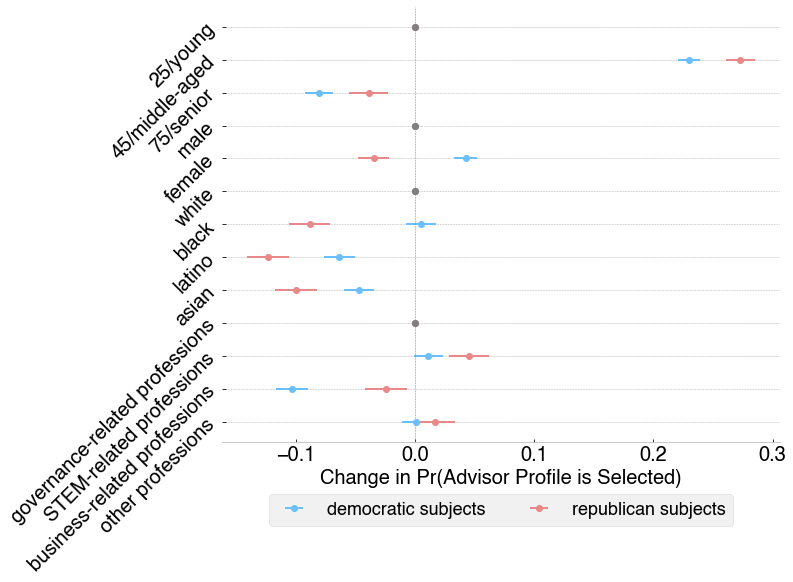

In [49]:
# plot!
fig, axs = plt.subplots(figsize=(10, 8))
axs.set_facecolor('white')
axs.xaxis.grid(False)
axs.axvline(0, linestyle='--', color='grey', lw=0.5)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
dem = plt.errorbar(values_dem, names_dem, xerr=err_values_dem, fmt='o', color='#6abffc')
rep = plt.errorbar(values_rep, names_rep, xerr=err_values_rep, fmt='o', color='#e88888')
legend = [dem, rep]
plt.errorbar(values_baseline, names_baseline, xerr=err_values_baseline, fmt='o', color='grey')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=45)
plt.xlabel('Change in Pr(Advisor Profile is Selected)', fontsize=20)
axs.legend(legend, ['democratic subjects', 'republican subjects'], loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=False, ncol=3, fontsize='18')